Brain Tumour Segmentation

# Setup

In [1]:
import os
import numpy as np 
import random
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers

# Get the Data

## Get the Data path

In [2]:
import glob

CURRENT_PATH = os.getcwd()
ABS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, os.pardir))

DATASET_PATH = ABS_PATH + "/Dataset"

X_PATHs = glob.glob(DATASET_PATH + "/*/*img.npy")
np.random.shuffle(X_PATHs)
SEG_PATHs = [PATH.replace("img", "seg") for PATH in X_PATHs]

In [3]:
X_shape = np.load(X_PATHs[0]).shape
X_shape

(240, 240, 3)

In [4]:
y_shape = np.load(SEG_PATHs[0]).shape
y_shape

(240, 240)

In [5]:
img_shape = (240, 240)
n_channels = 3
n_classes = 1

# Visualize the Data

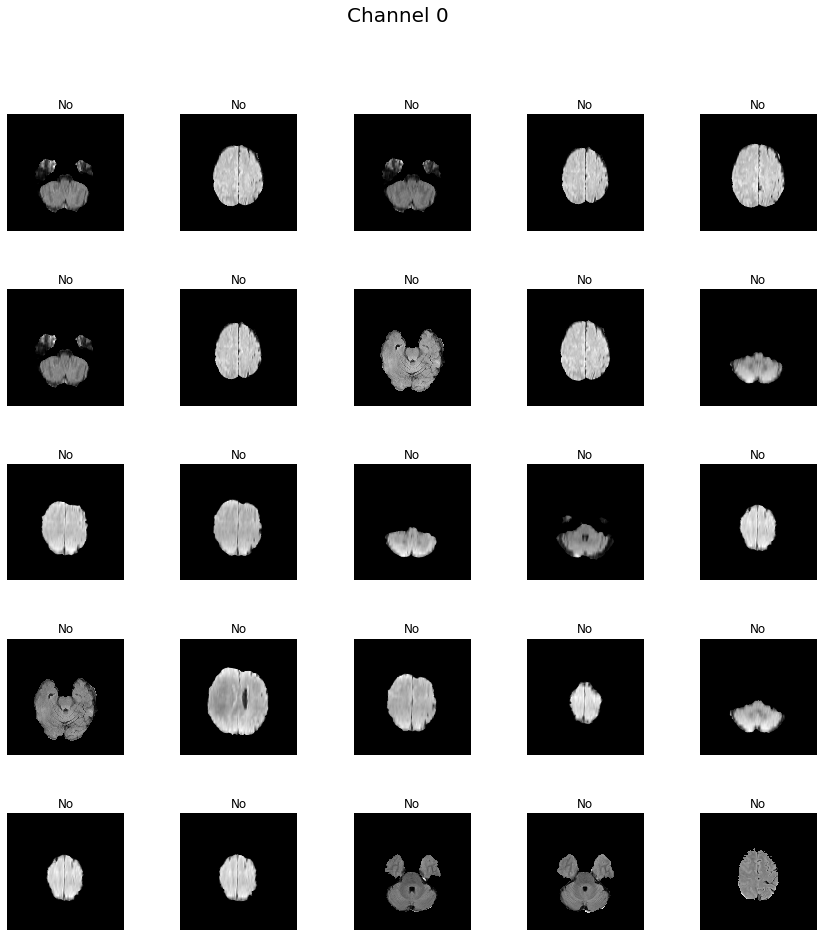

In [34]:
n_rows = 5
n_cols = 5
ch = 0 # channel
plt.figure(figsize=(n_cols * 3, n_rows * 3))
plt.suptitle("Channel %d"%ch, fontsize=20)

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        
        PATH_temp = X_PATH[index]
        img_temp = np.load(PATH_temp)[:, :, ch]
        plt.imshow(img_temp, cmap="gray", interpolation="nearest")
        plt.axis('off')
        
        title_temp = "Yes" if "Yes" in PATH_temp else "No"
        plt.title(title_temp, fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [36]:
def plot_images(instances, images_per_row=8, height = 240, width = 240):
    """shape of image is (n, -1)"""
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, height * width))], axis=0)
    
    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, height, width))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * height, images_per_row * width)
    plt.imshow(big_image, cmap="gray")
    plt.axis("off")

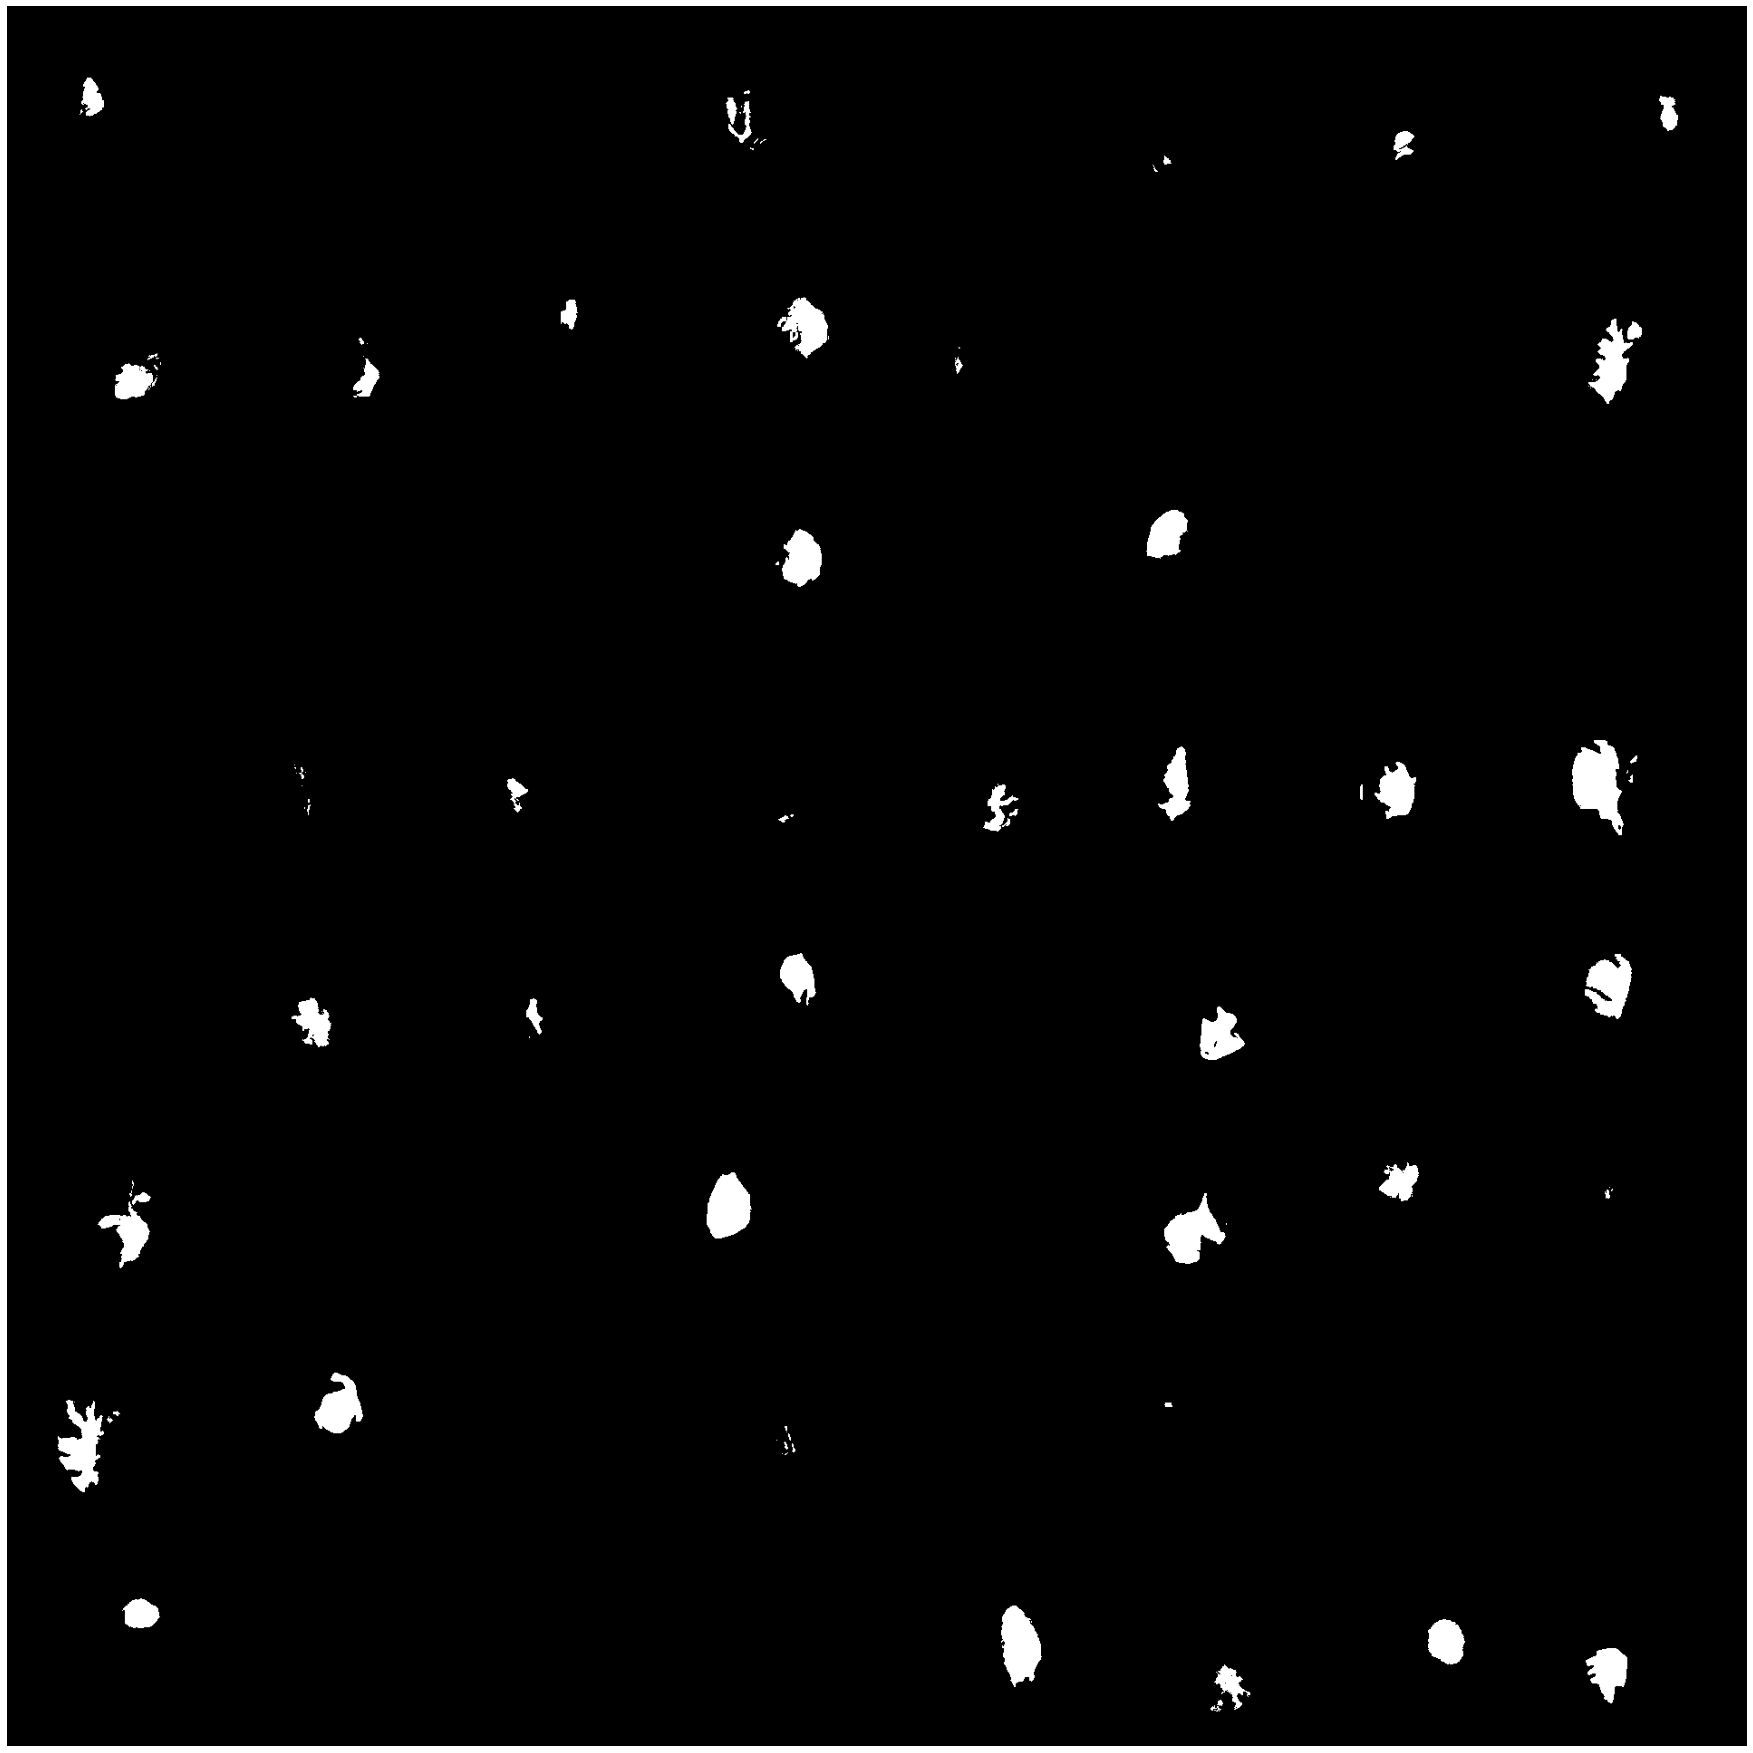

In [11]:
n_plots = 64
seg_plots = np.zeros(((n_plots,) + seg_shape))
for (i, PATH) in enumerate(SEG_PATH[:n_plots]):
    seg_plots[i] = np.load(PATH)

plt.figure(figsize=(32, 32))
plot_images(seg_plots.reshape(n_plots, -1))

# Prepare the Data

## Train and Validation Split

In [6]:
val_split = 0.1
n = len(X_PATHs)
m = round(n*(1 - val_split))

X_train, y_train = X_PATHs[:m], SEG_PATHs[:m]
X_val, y_val = X_PATHs[m:], SEG_PATHs[m:]

## Data Augmentation

### Rotation

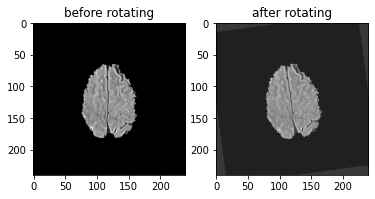

In [113]:
a_X = np.load(random.choice(X_PATHs))
rotated_X = tf.keras.preprocessing.image.random_rotation(
    a_X, rg=20, fill_mode='constant',
    cval=0.0, interpolation_order=3,
    row_axis=0, col_axis=1, channel_axis=2,
)

plt.subplot(121)
plt.title("before rotating")
plt.imshow(a_X[:, :, 0], cmap="gray")

plt.subplot(122)
plt.title("after rotating")
plt.imshow(rotated_X[:, :, 0], cmap="gray")

plt.show()

### Shift

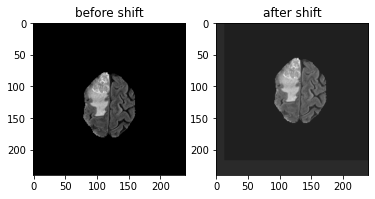

In [115]:
a_X = np.load(random.choice(X_PATHs))
shifted_X = tf.keras.preprocessing.image.random_shift(
    a_X, wrg=0.1, hrg=0.1, 
    row_axis=0, col_axis=1, channel_axis=2,
    fill_mode="constant", cval=0.0, interpolation_order=3
)

plt.subplot(121)
plt.title("before shift")
plt.imshow(a_X[:, :, 0], cmap="gray")

plt.subplot(122)
plt.title("after shift")
plt.imshow(shifted_X[:, :, 0], cmap="gray")

plt.show()

### Shearing

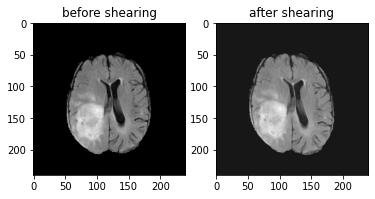

In [155]:
a_X = np.load(random.choice(X_PATHs))
X_sheared = tf.keras.preprocessing.image.random_shear(
    a_X, intensity=10, 
    row_axis=0, col_axis=1, channel_axis=2,
    fill_mode='nearest', cval=0.0, interpolation_order=3
)

plt.subplot(121)
plt.title("before shearing")
plt.imshow(a_X[:, :, 0], cmap="gray")

plt.subplot(122)
plt.title("after shearing")
plt.imshow(X_sheared[:, :, 0], cmap="gray")

plt.show()

### Zooming

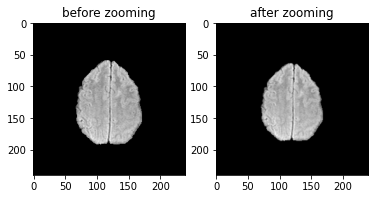

In [212]:
a_X = np.load(random.choice(X_PATHs))
a_X = np.load(X_PATHs[0])

tf.random.set_seed(42)
X_zoomed = tf.keras.preprocessing.image.random_zoom(
    a_X, zoom_range=(0.8, 1.2),
    row_axis=0, col_axis=1, channel_axis=2,
    fill_mode='nearest', cval=0.0, interpolation_order=1,
)


plt.subplot(121)
plt.title("before zooming")
plt.imshow(a_X[:, :, 0], cmap="gray")

plt.subplot(122)
plt.title("after zooming")
plt.imshow(X_zoomed[:, :, 0], cmap="gray")

plt.show()

## pipeline

In [7]:
from keras.preprocessing import image

def image_preprocessing(img):
    params = {
        "row_axis": 0, 
        "col_axis": 1, 
        "channel_axis": 2,
        "fill_mode": "constant",
        "cval": 0.0,
        "interpolation_order": 3,
    }
    img = image.random_rotation(img, rg=10, **params)
    img = image.random_shift(img, wrg=0.1, hrg=0.1, **params)
    img = image.random_shear(img, intensity=5, **params)
    img = image.random_zoom(img, zoom_range=(0.9, 1.1), **params)
    
    return img

In [8]:
def transform_img_and_seg(IMG_PATH, SEG_PATH):
    img_seg = np.concatenate(
        (np.load(IMG_PATH), np.expand_dims(np.load(SEG_PATH), axis=-1)),
        axis=-1,
    )
    
    transformed = image_preprocessing(img_seg)
    
    return (transformed[:, :, :3], np.expand_dims(transformed[:, :, -1], axis=-1))
    

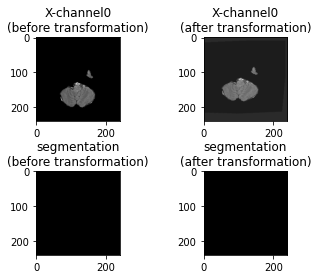

In [9]:
a_X_PATH = random.choice(X_PATHs)
a_Y_PATH = a_X_PATH.replace("img", "seg")

a_X = np.load(a_X_PATH)
a_y = np.expand_dims(np.load(a_Y_PATH), axis=-1)

X_transformed, y_transformed = transform_img_and_seg(a_X_PATH, a_Y_PATH)

plt.subplot(221)
plt.title("X-channel0\n(before transformation)")
plt.imshow(a_X[:, :, 0], cmap="gray")

plt.subplot(222)
plt.title("X-channel0\n(after transformation)")
plt.imshow(X_transformed[:, :, 0], cmap="gray")

plt.subplot(223)
plt.title("segmentation\n(before transformation)")
plt.imshow(a_y[:, :, 0], cmap="gray")

plt.subplot(224)
plt.title("segmentation\n(after transformation)")
plt.imshow(y_transformed[:, :, 0], cmap="gray")

plt.subplots_adjust(wspace=0.0, hspace=0.6)
plt.show()

## Data Generator

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 list_IDs,
                 img_shape, batch_size,
                 n_channels,
                 shuffle=True):
        'Initialization'
        self.list_IDs = list_IDs
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        batch_size = self.batch_size
        indices = self.indices[index*batch_size : (index+1)*batch_size]

        # Find list of PATHs
        list_IDs_temp = [self.list_IDs[i] for i in indices]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (batch_size, img_shape, n_channels)
        # allocate space
        X = np.empty((self.batch_size, *self.img_shape, self.n_channels))
        y = np.empty((self.batch_size, *self.img_shape, 1), dtype=int)
        y_paths_temp = [ID.replace("img", "seg") for ID in list_IDs_temp]

        # Generate data
        for i, (X_ID, y_ID) in enumerate(zip(list_IDs_temp, y_paths_temp)):
            X[i], y[i] = transform_img_and_seg(X_ID, y_ID)
            
        return X, y

In [11]:
params = {
    "img_shape": img_shape, 
    "batch_size": 32,
    "n_channels": n_channels, 
}

training_generator = DataGenerator(X_train, **params)
validation_generator = DataGenerator(X_val, **params)

# Can not use `Image generator` because the dataformat is `.npy`

## Create `Seg` and `Img` folder

In [ ]:
import shutil

CURRENT_PATH = os.getcwd()
ABS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, os.pardir))

DATASET_PATH = ABS_PATH + "/Dataset"

IMG_PATH = DATASET_PATH + "/Img"
SEG_PATH = DATASET_PATH + "/Seg"

for PATH in X_PATHs:
    shutil.copy(PATH, IMG_PATH)

for PATH in SEG_PATHs:
    shutil.copy(PATH, SEG_PATH)

## `ImageDataGenerator`

In [199]:
from keras.preprocessing.image import ImageDataGenerator

params = {
    "featurewise_center": False, "samplewise_center": False,
    "rotation_range": 0, "width_shift_range": 0.0,
    "height_shift_range": 0.0, "shear_range": 0.0, "zoom_range": 0.0,
    "fill_mode": "constant", "cval": 0.0,
    "validation_split": 0.0, 
}

img_datagen = ImageDataGenerator(**params)

SEED = 42 # IMPORTANT!!!
img_generator =img_datagen.flow_from_directory(IMG_PATH,
                                                    class_mode=None, seed=SEED)

mask_generator = img_datagen.flow_from_directory(SEG_PATH,
                                                   class_mode=None, seed=SEED)



Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


# Build the Model

## Loss Function

In [13]:
def dice_coef(y_true, y_pred, eps=1e-8):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    nume = tf.reduce_sum(abs(y_true * y_pred))
    deno = tf.reduce_sum(y_true**2 + y_pred**2) + eps
    
    return 2*nume/deno

def dice_loss(y_true, y_pred, eps=1e-8):
    return 1 - dice_coef(y_true, y_pred, eps=1e-8)

## Build Model

In [23]:
def get_blocks(inputs, depth, pool_win=2, filters_root=64):
    x = inputs
    params = {
        "kernel_size": 3,
        "padding": "same",
        "activation": "relu",
    }
    
    for i in range(depth):
        temp_filters = 2**i*filters_root
        x = layers.Conv2D(filters=temp_filters, **params)(x)
        x = layers.Conv2D(filters=temp_filters, **params)(x)
        x = layers.MaxPool2D(pool_size=pool_win)(x)
    
    for i in range(depth):
        temp_filters = 2**(depth-i-1)*filters_root
        x = layers.Conv2DTranspose(filters=temp_filters, strides=2, **params)(x)
        x = layers.Conv2D(filters=temp_filters, **params)(x)

    return x


def get_model(img_shape, n_channels, n_classes, depth):
    inputs = keras.Input((img_shape + (n_channels,)))
    x = get_blocks(inputs, depth=depth)
    outputs = layers.Conv2D(
        filters=n_classes, kernel_size=1, strides=1,
        activation='sigmoid',
    )(x)
    model = keras.Model(inputs, outputs, name="depth_1")    
    return model

### Depth 1

In [24]:
params = {
    "depth": 1,
    "img_shape": img_shape,
    "n_channels": n_channels,
    "n_classes": n_classes,
}
   
model = get_model(**params)
model.summary()

Model: "depth_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 240, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 240, 240, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 120, 120, 64)     0         
 2D)                                                             
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 240, 240, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 240, 64)      3692

In [24]:
model.compile(
    loss=dice_loss, 
    optimizer="adam",
    metrics=[dice_coef]
)

In [25]:
from time import time

start = time()

epochs = 50
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef",
    mode='max',
    patience=5,
)

history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[earlystopping]
)

train_time = time()-start

print("traing time(s):", train_time)

Epoch 1/50
151/151 [==============================] - 1067s 7s/step - loss: 0.4421 - dice_coef: 0.5579 - val_loss: 0.3785 - val_dice_coef: 0.6215
Epoch 2/50
151/151 [==============================] - 1084s 7s/step - loss: 0.3673 - dice_coef: 0.6327 - val_loss: 0.3559 - val_dice_coef: 0.6441
Epoch 3/50
151/151 [==============================] - 1061s 7s/step - loss: 0.3538 - dice_coef: 0.6462 - val_loss: 0.3543 - val_dice_coef: 0.6457
Epoch 4/50
151/151 [==============================] - 1154s 8s/step - loss: 0.3471 - dice_coef: 0.6529 - val_loss: 0.3677 - val_dice_coef: 0.6323
Epoch 5/50
151/151 [==============================] - 1691s 11s/step - loss: 0.3492 - dice_coef: 0.6508 - val_loss: 0.3529 - val_dice_coef: 0.6471
Epoch 6/50
151/151 [==============================] - 1607s 11s/step - loss: 0.3404 - dice_coef: 0.6596 - val_loss: 0.3469 - val_dice_coef: 0.6531
Epoch 7/50
151/151 [==============================] - 1639s 11s/step - loss: 0.3357 - dice_coef: 0.6643 - val_loss: 0.3421

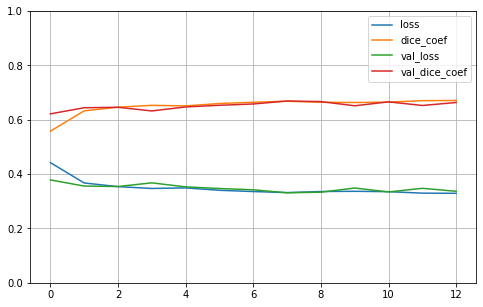

In [26]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [27]:
model.save("2_8.h5")

### Depth 2

In [25]:
params = {
    "depth": 2,
    "img_shape": img_shape,
    "n_channels": n_channels,
    "n_classes": n_classes,
}
   
model = get_model(**params)
model.summary()

Model: "depth_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 240, 240, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 240, 240, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 120, 120, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 120, 120, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 120, 120, 128)     147584    
                                                           

In [26]:
model.compile(
    loss=dice_loss, 
    optimizer="adam",
    metrics=[dice_coef]
)

from time import time

start = time()

epochs = 50
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef",
    mode='max',
    patience=5,
)

history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[earlystopping]
)

train_time = time()-start

print("traing time(s):", train_time)

Epoch 1/50
151/151 [==============================] - 1844s 12s/step - loss: 0.5016 - dice_coef: 0.4984 - val_loss: 0.3740 - val_dice_coef: 0.6260
Epoch 2/50
151/151 [==============================] - 1810s 12s/step - loss: 0.3579 - dice_coef: 0.6421 - val_loss: 0.3413 - val_dice_coef: 0.6587
Epoch 3/50
151/151 [==============================] - 1808s 12s/step - loss: 0.3414 - dice_coef: 0.6586 - val_loss: 0.3421 - val_dice_coef: 0.6579
Epoch 4/50
151/151 [==============================] - 1816s 12s/step - loss: 0.3407 - dice_coef: 0.6593 - val_loss: 0.3387 - val_dice_coef: 0.6613
Epoch 5/50
151/151 [==============================] - 1829s 12s/step - loss: 0.3256 - dice_coef: 0.6744 - val_loss: 0.3185 - val_dice_coef: 0.6815
Epoch 6/50
151/151 [==============================] - 1830s 12s/step - loss: 0.3231 - dice_coef: 0.6769 - val_loss: 0.3197 - val_dice_coef: 0.6803
Epoch 7/50
151/151 [==============================] - 1820s 12s/step - loss: 0.3218 - dice_coef: 0.6782 - val_loss: 0.

In [27]:
model.save("depth_2.h5")

### Depth 3

In [28]:
model.compile(
    loss=dice_loss, 
    optimizer="adam",
    metrics=[dice_coef]
)

from time import time

start = time()

epochs = 50
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef",
    mode='max',
    patience=5,
)

history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[earlystopping]
)

train_time = time()-start

print("traing time(s):", train_time)

Epoch 1/50
151/151 [==============================] - 1925s 13s/step - loss: 0.2813 - dice_coef: 0.7187 - val_loss: 0.2895 - val_dice_coef: 0.7105
Epoch 2/50
151/151 [==============================] - 1919s 13s/step - loss: 0.2828 - dice_coef: 0.7172 - val_loss: 0.2877 - val_dice_coef: 0.7123
Epoch 3/50
151/151 [==============================] - 1921s 13s/step - loss: 0.2804 - dice_coef: 0.7196 - val_loss: 0.3080 - val_dice_coef: 0.6920
Epoch 4/50
151/151 [==============================] - 1921s 13s/step - loss: 0.2823 - dice_coef: 0.7177 - val_loss: 0.2853 - val_dice_coef: 0.7147
Epoch 5/50
151/151 [==============================] - 1931s 13s/step - loss: 0.2818 - dice_coef: 0.7182 - val_loss: 0.2926 - val_dice_coef: 0.7074
Epoch 6/50
151/151 [==============================] - 1938s 13s/step - loss: 0.2776 - dice_coef: 0.7224 - val_loss: 0.2885 - val_dice_coef: 0.7115
Epoch 7/50
151/151 [==============================] - 1928s 13s/step - loss: 0.2760 - dice_coef: 0.7240 - val_loss: 0.

In [29]:
model.save("depth_3.h5")

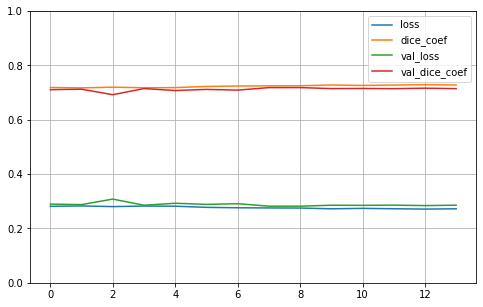

In [43]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Analyse the Result

In [40]:
custom_objects = {
    "dice_coef": dice_coef,
    "dice_loss": dice_loss,
}

model = keras.models.load_model(
    "depth_2.h5", 
    custom_objects=custom_objects,
)

In [41]:
n_samples = 5
X_test = np.zeros(((n_samples,) + img_shape + (n_channels,)))
y_test = np.zeros(((n_samples,) + img_shape))

for i in range(n_samples):
    X_test[i] = np.load(X_PATHs[i])
    y_test[i] = np.load(SEG_PATHs[i])

In [42]:
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0).reshape(((n_samples,) + img_shape))

dice_coef(y_pred, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.87575465>

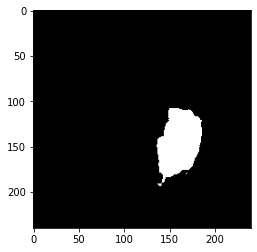

In [33]:
plt.imshow(y_test[0], cmap="gray")

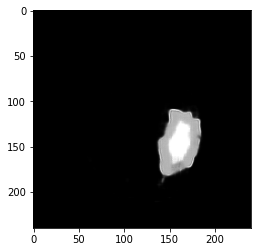

In [34]:
plt.imshow(y_pred_prob[0], cmap="gray")

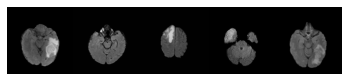

In [37]:
X_test_ch0 = X_test[:, :, :, 0]

plot_images(X_test_ch0.reshape(5, -1), images_per_row=5)

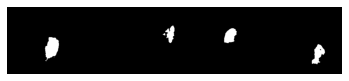

In [38]:
plot_images(y_test.reshape(5, -1), images_per_row=5)

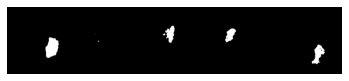

In [39]:
plot_images(np.asarray(y_pred).reshape(5, -1), images_per_row=5)